In [1]:
# Import packages.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import LSTM, Dense
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

In [2]:
# Read dataset.
df = pd.read_csv("df_subset.csv")

In [3]:
# Drop unneeded columns caused by merging.
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]

In [4]:
# Add calculated fields.
df["wind_speed"] = np.sqrt(df["u"]**2 + df["v"]**2)
df["wind_dir"] = np.sqrt(df["u"]**2 + df["v"]**2)

In [73]:
# Subset to a specific point.
df_subset = df[df["lat"] == -87.1875]
df_subset = df_subset[df_subset["lon"] == 0]
df_subset = df_subset[df_subset["level"] == 1000]
df_subset["time"] = pd.to_datetime(df_subset["time"])
df_subset = df_subset.drop(columns=["lat", "lon", "level"])

# Split train-test-validation sets
test_real = df_subset[df_subset["time"] >= "2018-01-31"]
val_real = df_subset[(df_subset["time"] >= "2018-01-30") & (df_subset["time"] < "2018-01-31")]
train_real = df_subset[df_subset["time"] < "2018-01-29"]

# Seperate time field.
train_time = train_real.pop("time")
val_time = val_real.pop("time")
test_time = test_real.pop("time")

# Split label data from the rest of the datasets.
#train_y_real = train_real.pop("t")
#val_y_real = val_real.pop("t")
#test_y_real = test_real.pop("t")

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_subset.drop(columns=["time", "t"]))

train_scaled = scaler.fit_transform(train_real)
val_scaled = scaler.fit_transform(val_real)
test_scaled = scaler.fit_transform(test_real)

train_df = pd.DataFrame(train_scaled, index=train_real.index, columns=train_real.columns)
val_df = pd.DataFrame(val_scaled, index=val_real.index, columns=val_real.columns)
test_df = pd.DataFrame(test_scaled, index=test_real.index, columns=test_real.columns)

# Convert to array
#train_y_real = train_y_real.to_numpy()
#val_y_real = val_y_real.to_numpy()
#test_y_real = test_y_real.to_numpy()

# Reshape for model.
#train_real = train_real.reshape((train_real.shape[0], 1, train_real.shape[1]))
#val_real = val_real.reshape((val_real.shape[0], 1, val_real.shape[1]))
#test_real = test_real.reshape((test_real.shape[0], 1, test_real.shape[1]))

In [20]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [48]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='t', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds


    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result




In [49]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['t'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['t']

In [9]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['t'])
single_step_window
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 16)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 16)
Inputs shape: (3, 6, 16)
Labels shape: (3, 1, 1)


In [50]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['t'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['t']

In [57]:
print(list(wide_window.example))

[<tf.Tensor: shape=(32, 24, 16), dtype=float32, numpy=
array([[[0.17211793, 0.54560506, 0.3004176 , ..., 0.        ,
         0.6451779 , 0.6451779 ],
        [0.20341426, 0.5489219 , 0.33952194, ..., 0.        ,
         0.629115  , 0.629115  ],
        [0.22048222, 0.5472638 , 0.38814107, ..., 0.        ,
         0.60972005, 0.60972005],
        ...,
        [0.5007107 , 0.6832504 , 0.7377581 , ..., 0.        ,
         0.22158675, 0.22158675],
        [0.51209277, 0.6301824 , 0.7483171 , ..., 0.        ,
         0.18256499, 0.18256499],
        [0.5220499 , 0.57877237, 0.74889743, ..., 0.        ,
         0.14221658, 0.14221658]],

       [[0.77809626, 0.66500837, 0.7099094 , ..., 0.        ,
         0.2524251 , 0.2524251 ],
        [0.7709821 , 0.6185739 , 0.7135066 , ..., 0.        ,
         0.24605525, 0.24605525],
        [0.7809393 , 0.5704807 , 0.7094452 , ..., 0.        ,
         0.23585051, 0.23585051],
        ...,
        [0.67994285, 0.67495805, 0.77106035, ..., 0. 

In [30]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 16)
Labels shape (batch, time, features): (32, 1, 1)


In [31]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [32]:
LABEL_WIDTH = 24
CONV_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['t'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['t']

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


In [37]:
MAX_EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(wide_window.train, epochs=MAX_EPOCHS,
                  validation_data=wide_window.val,
                  callbacks=[early_stopping])

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
21/21 [==============================] - 2s 14ms/step - loss: 0.0029 - mean_absolute_error: 0.0408
Epoch 2/20
21/21 [==============================] - 0s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0269
Epoch 3/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0245
Epoch 4/20
21/21 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0234
Epoch 5/20
21/21 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0224
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 9.9297e-04 - mean_absolute_error: 0.0212
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 9.1755e-04 - mean_absolute_error: 0.0207
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 8.1018e-04 - mean_absolute_error: 0.0194
Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 7.3453e-04 - mean_absolute_error: 0.0186


C:\Users\obsid\anaconda3\envs\tf_310\lib\site-packages\keras\utils\generic_utils.py:923: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

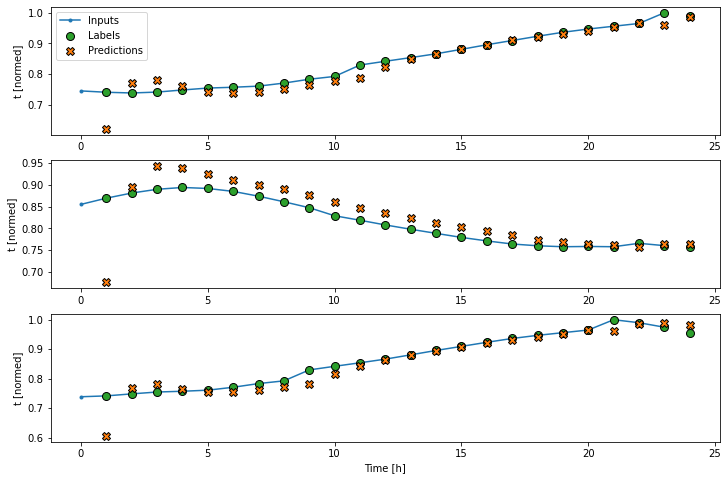

In [35]:
wide_window.plot(lstm_model)

In [58]:
train_df

,z,pv,r,q,t,u,vo,v,u10,v10,t2m,tisr,tcc,tp,wind_speed,wind_dir
12,0.631579,0.199005,0.244720,0.484147,0.854542,0.435014,0.719156,0.206846,0.435846,0.204804,0.779092,0.475620,0.000000,0.0,0.655007,0.655007
25,0.630157,0.242123,0.252843,0.464024,0.833431,0.413284,0.733225,0.213868,0.413737,0.212485,0.762404,0.474448,0.000000,0.0,0.659920,0.659920
38,0.640114,0.281924,0.263982,0.451829,0.816540,0.387454,0.733766,0.222645,0.388061,0.221032,0.748417,0.491032,0.000000,0.0,0.667337,0.667337
51,0.647228,0.326700,0.269668,0.444512,0.803145,0.371054,0.733225,0.227911,0.371300,0.226550,0.734879,0.524651,0.000000,0.0,0.673584,0.673584
64,0.645804,0.371476,0.273033,0.441463,0.793389,0.357524,0.738095,0.225571,0.357392,0.224061,0.731889,0.572780,0.000000,0.0,0.687291,0.687291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8683,0.742532,0.398010,0.484335,0.082927,0.293680,0.300123,0.758117,0.476594,0.297554,0.473223,0.177208,0.233348,0.482520,0.0,0.476562,0.476562
8696,0.748221,0.432835,0.505222,0.078049,0.290186,0.291513,0.751082,0.489175,0.289066,0.485340,0.163638,0.162145,0.267606,0.0,0.476084,0.476084
8709,0.729732,0.402985,0.527152,0.071952,0.282615,0.286388,0.758117,0.486542,0.283717,0.483501,0.145856,0.096891,0.096654,0.0,0.485208,0.485208
8722,0.708393,0.466003,0.590276,0.061586,0.246068,0.287003,0.754870,0.484201,0.284359,0.480796,0.131355,0.042361,0.037172,0.0,0.486521,0.486521


In [77]:
train_df.shape

(672, 15)

In [78]:
# Convert to array
#train_y = train_df.pop("t")
#val_y = val_df.pop("t")
#test_y = test_df.pop("t")

#train_df = train_df.to_numpy()
#val_df = val_df.to_numpy()
#test_df = test_df.to_numpy()

# Reshape for model.
train_df = train_df.reshape((train_df.shape[0], 1, train_df.shape[1]))
val_df = val_df.reshape((val_df.shape[0], 1, val_df.shape[1]))
test_df = test_df.reshape((test_df.shape[0], 1, test_df.shape[1]))

In [83]:
# Create the model
model = tf.keras.models.Sequential()
model.add(LSTM(50, input_shape=(train_df.shape[1], train_df.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0003, restore_best_weights=True)

# Fitting
#history = model.fit(train_df.loc[:,train_df], train_y_real, epochs=500, batch_size=72, 
#                    validation_data=(val_real, val_y_real), verbose=2, 
#                    shuffle=False, callbacks=[early_stopping])

history = model.fit(train_df, train_y, 
                    epochs=500, batch_size=72, 
                    validation_data = (val_df, val_y), 
                    verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
10/10 - 2s - loss: 0.3080 - val_loss: 0.2680 - 2s/epoch - 186ms/step
Epoch 2/500
10/10 - 0s - loss: 0.0296 - val_loss: 0.0538 - 81ms/epoch - 8ms/step
Epoch 3/500
10/10 - 0s - loss: 0.0765 - val_loss: 0.1515 - 83ms/epoch - 8ms/step
Epoch 4/500
10/10 - 0s - loss: 0.0292 - val_loss: 0.2168 - 79ms/epoch - 8ms/step
Epoch 5/500
10/10 - 0s - loss: 0.0150 - val_loss: 0.1595 - 80ms/epoch - 8ms/step
Epoch 6/500
10/10 - 0s - loss: 0.0175 - val_loss: 0.2529 - 81ms/epoch - 8ms/step
Epoch 7/500
10/10 - 0s - loss: 0.0098 - val_loss: 0.2364 - 80ms/epoch - 8ms/step


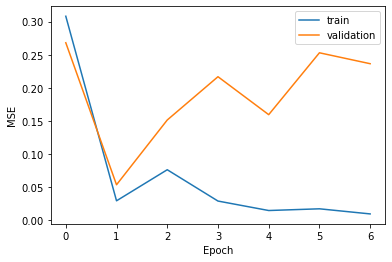

In [85]:
# Plot the training history and save the graph.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.savefig("Train_History.png")

In [9]:
# Predict the test set and find MAE
yhat = model.predict(test_real)
np.mean(abs(yhat - test_y_real))

1/1 [==============================] - 0s 351ms/step


0.6229213357543963

In [10]:
# Find MSE
np.mean((yhat - test_y_real)**2)

0.4421159510833188